In [1]:
# import environment
from marketsai.economies.townsend.townsend import Townsend

# import ray
from ray import tune, shutdown, init
from ray.tune.registry import register_env

# from ray.tune.integration.mlflow import MLflowLoggerCallback

# For custom metrics (Callbacks)
from ray.rllib.agents.callbacks import DefaultCallbacks
from ray.rllib.env import BaseEnv
from ray.rllib.evaluation import MultiAgentEpisode, RolloutWorker
from ray.rllib.policy import Policy

# common imports
from typing import Dict
import numpy as np
import seaborn as sn
import sys
import pandas as pd
import matplotlib.pyplot as plt
import json

# import logging
# import random
# import math

""" STEP 0: Experiment configs """

# global configs
DATE = "Sep3_"
TEST = False
SAVE_EXP_INFO = True
PLOT_PROGRESS = True
sn.color_palette("Set2")
SAVE_PROGRESS_CSV = True

if TEST:
    OUTPUT_PATH_EXPERS = "/Users/matiascovarrubias/Dropbox/RL_macro/Tests/"
    OUTPUT_PATH_FIGURES = "/Users/matiascovarrubias/Dropbox/RL_macro/Tests/"
else:
    OUTPUT_PATH_EXPERS = "/Users/matiascovarrubias/Dropbox/RL_macro/Experiments/"
    OUTPUT_PATH_FIGURES = "/Users/matiascovarrubias/Dropbox/RL_macro/Documents/Figures/"

ALGO = "PPO"  # either PPO" or "SAC"
DEVICE = "native"  # either "native" or "server"
n_firms_LIST = [2, 3, 4, 5]  # list with number of agents for each run
ITERS_TEST = 2 # number of iteration for test
ITERS_RUN = 1000 # number of iteration for fullrun


# Other economic Hiperparameteres.
ENV_HORIZON = 1000
N_CAPITAL = 1
BETA = 0.98  # discount parameter

/Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  warnings.warn(


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
""" STEP 1: Paralleliztion and batch options"""
# Parallelization options
NUM_CPUS = 4
NUM_CPUS_DRIVER = 1
NUM_TRIALS = 6
NUM_ROLLOUT = ENV_HORIZON * 1
NUM_ENV_PW = 1  # num_env_per_worker
NUM_GPUS = 0
BATCH_ROLLOUT = 1
NUM_MINI_BATCH = NUM_CPUS_DRIVER

N_WORKERS = (NUM_CPUS - NUM_TRIALS * NUM_CPUS_DRIVER) // NUM_TRIALS
BATCH_SIZE = NUM_ROLLOUT * (max(N_WORKERS, 1)) * NUM_ENV_PW * BATCH_ROLLOUT

print(N_WORKERS, BATCH_SIZE)

# define length of experiment (MAX_STEPS) and experiment name
if TEST == True:
    MAX_STEPS = ITERS_TEST * BATCH_SIZE
else:
    MAX_STEPS = ITERS_RUN * BATCH_SIZE

CHKPT_FREQ = 10

stop = {"timesteps_total": MAX_STEPS}
# Initialize ray
shutdown()
init(
    num_cpus=NUM_CPUS,
    num_gpus=NUM_GPUS,
    # logging_level=logging.ERROR,
)

# Define environment, which should be imported from a class
ENV_LABEL = "townsend"
register_env(ENV_LABEL, Townsend)

-1 1000


2021-09-03 20:28:38,266	INFO services.py:1267 -- View the Ray dashboard at http://127.0.0.1:8265


In [3]:
""" STEP 2: set custom metrics such as discounted rewards to keep track of through leraning"""
# Define custom metrics using the Callbacks class
# See rllib documentation on Callbacks. They are a way of inserting code in different parts of the pipeline.

# function to get discounted rewards for analysys
def process_rewards(r):
    """Compute discounted reward from a vector of rewards."""
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, len(r))):
        running_add = running_add * BETA + r[t]
        discounted_r[t] = running_add
    return discounted_r[0]


class MyCallbacks(DefaultCallbacks):
    def on_episode_start(
        self,
        *,
        worker: RolloutWorker,
        base_env: BaseEnv,
        policies: Dict[str, Policy],
        episode: MultiAgentEpisode,
        env_index: int,
        **kwargs,
    ):
        # Make sure this episode has just been started (only initial obs
        # logged so far).

        assert episode.length == 0, (
            "ERROR: `on_episode_start()` callback should be called right "
            "after env reset!"
        )
        episode.user_data["rewards"] = []

    def on_episode_step(
        self,
        *,
        worker: RolloutWorker,
        base_env: BaseEnv,
        episode: MultiAgentEpisode,
        env_index: int,
        **kwargs,
    ):
        if episode.length > 1:  # at t=0, previous rewards are not defined
            rewards = episode.prev_reward_for("firm_0")
            episode.user_data["rewards"].append(rewards)

    def on_episode_end(
        self,
        *,
        worker: RolloutWorker,
        base_env: BaseEnv,
        policies: Dict[str, Policy],
        episode: MultiAgentEpisode,
        env_index: int,
        **kwargs,
    ):
        discounted_rewards = process_rewards(episode.user_data["rewards"])
        episode.custom_metrics["discounted_rewards"] = discounted_rewards


In [4]:
""" STEP 3: Environment and Algorithm configuration """


# environment config including evaluation environment (without exploration)
env_config={
    "horizon": ENV_HORIZON,
    "N_firms": 2,
    "eval_mode": False,
    "analysis_mode": False,
    "simul_mode": False,
    "max_savings": 0.6,
    "parameters": {
        "delta": 0,
        "alpha": 1,
        "beta": 0.98,
        "phi": 0.5,
        "A": 1,
        "tfp": 0.1,
        "rho": 0.9,
        "theta_0": 10,
        "mean_w": 0,
        "var_w": 1,
        "var_epsilon": 1,
        "var_theta": 2,
    },
}

env_config_eval = env_config.copy()
env_config_eval["eval_mode"] = True

# we instantiate the environment to extrac relevant info
" CHANGE HERE "
env = Townsend(env_config)

# common configuration

"""
NOTE: in order to do hyperparameter optimization, you can select a range of values 
with tune.choice([0.05,1] for random choice or tune.grid_search([0.05,1]) for fix search.
# see https://docs.ray.io/en/master/tune/key-concepts.html#search-spaces for spaces and their definition.
# se at the bottom (Annex_env_hyp) for an explanation how to do the same with environment parameters.
"""
common_config = {
    # CUSTOM METRICS
    "callbacks": MyCallbacks,
    # ENVIRONMENT
    "gamma": BETA,
    "env": ENV_LABEL,
    "env_config": env_config,
    "horizon": ENV_HORIZON,
    # MODEL
    "framework": "torch",
    # "model": tune.grid_search([{"use_lstm": True}, {"use_lstm": False}]),
    # TRAINING CONFIG
    "num_workers": N_WORKERS,
    "create_env_on_driver": False,
    "num_gpus": NUM_GPUS / NUM_TRIALS,
    "num_envs_per_worker": NUM_ENV_PW,
    "num_cpus_for_driver": NUM_CPUS_DRIVER,
    "rollout_fragment_length": NUM_ROLLOUT,
    "train_batch_size": BATCH_SIZE,
    # EVALUATION
    "evaluation_interval": 1,
    "evaluation_num_episodes": 1,
    "evaluation_config": {
        "explore": False,
        "env_config": env_config_eval,
    },
    # MULTIAGENT,
    "multiagent": {
        "policies": {
            "firm": (
                None,
                env.observation_space["firm_0"],
                env.action_space["firm_0"],
                {},
            ),
        },
        "policy_mapping_fn": (lambda agent_id: agent_id.split("_")[0]),
        "replay_mode": "independent",  # you can change to "lockstep".
    },
}

# Configs specific to the chosel algorithms, INCLUDING THE LEARNING RATE
ppo_config = {
    "lr": 0.0005,
    # "lr_schedule": [[0, 0.00005], [MAX_STEPS * 1 / 2, 0.00001]],
    "sgd_minibatch_size": BATCH_SIZE // NUM_MINI_BATCH,
    "num_sgd_iter": 1,
    "batch_mode": "complete_episodes",
    "lambda": 0.98,
    "entropy_coeff": 0,
    "kl_coeff": 0.2,
    # "vf_loss_coeff": 0.5,
    # "vf_clip_param": tune.choice([5, 10, 20]),
    # "entropy_coeff_schedule": [[0, 0.01], [5120 * 1000, 0]],
    "clip_param": 0.2,
    "clip_actions": True,
}

sac_config = {
    "prioritized_replay": True,
}

if ALGO == "PPO":
    training_config = {**common_config, **ppo_config}
elif ALGO == "SAC":
    training_config = {**common_config, **sac_config}
else:
    training_config = common_config

In [5]:
""" STEP 4: run experiment """

exp_names = []
exp_dirs = []
checkpoints = []
best_rewards = []
best_configs = []
learning_dta = []



# RUN TRAINER
for n_firms in n_firms_LIST:
    EXP_LABEL = DEVICE + f"_{n_firms}_firms_"
    if TEST == True:
        EXP_NAME = EXP_LABEL + ENV_LABEL + "_test_" + DATE + ALGO
    else:
        EXP_NAME = EXP_LABEL + ENV_LABEL + "_run_" + DATE + ALGO

    env_config["N_firms"] = n_firms
    env_config_eval["N_firms"] = n_firms
    """ CHANGE HERE """
    env = Townsend(env_config)
    training_config["env_config"] = env_config
    training_config["evaluation_config"]["env_config"] = env_config_eval
    training_config["multiagent"] = {
        "policies": {
            "firm": (
                None,
                env.observation_space["firm_0"],
                env.action_space["firm_0"],
                {},
            ),
        },
        "policy_mapping_fn": (lambda agent_id: agent_id.split("_")[0]),
        "replay_mode": "independent",  # you can change to "lockstep".
    }

    analysis = tune.run(
        ALGO,
        name=EXP_NAME,
        config=training_config,
        stop=stop,
        checkpoint_freq=CHKPT_FREQ,
        checkpoint_at_end=True,
        metric="evaluation/custom_metrics/discounted_rewards_mean",
        mode="max",
        num_samples=NUM_TRIALS,
        # resources_per_trial={"gpu": 0.5},
    )

    exp_names.append(EXP_NAME)
    checkpoints.append(analysis.best_checkpoint)
    best_rewards.append(
        analysis.best_result["evaluation"]["custom_metrics"]["discounted_rewards_mean"]
    )
    best_configs.append(analysis.best_config)
    exp_dirs.append(analysis.best_logdir)
    learning_dta.append(
        analysis.best_dataframe[
            ["episodes_total", "evaluation/custom_metrics/discounted_rewards_mean"]
        ]
    )
    learning_dta[n_firms - 1].columns = ["episodes_total", f"{n_firms} households"]

Trial name,status,loc
PPO_townsend_0e084_00000,RUNNING,
PPO_townsend_0e084_00001,PENDING,
PPO_townsend_0e084_00002,PENDING,
PPO_townsend_0e084_00003,PENDING,
PPO_townsend_0e084_00004,PENDING,
PPO_townsend_0e084_00005,PENDING,


(pid=31897) WARNING:tensorflow:From /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=31897) Instructions for updating:
(pid=31897) non-resource variables are not supported in the long term
(pid=31899) WARNING:tensorflow:From /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=31899) Instructions for updating:
(pid=31899) non-resource variables are not supported in the long term
(pid=31898) WARNING:tensorflow:From /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packa

Trial name,status,loc
PPO_townsend_0e084_00000,RUNNING,
PPO_townsend_0e084_00001,RUNNING,
PPO_townsend_0e084_00002,RUNNING,
PPO_townsend_0e084_00003,RUNNING,
PPO_townsend_0e084_00004,PENDING,
PPO_townsend_0e084_00005,PENDING,


(pid=31897) 2021-09-03 20:28:47,770	WARNING deprecation.py:33 -- DeprecationWarning: `SampleBatch.data[..]` has been deprecated. Use `SampleBatch[..]` instead. This will raise an error in the future!
(pid=31899) 2021-09-03 20:28:47,906	WARNING deprecation.py:33 -- DeprecationWarning: `SampleBatch.data[..]` has been deprecated. Use `SampleBatch[..]` instead. This will raise an error in the future!
(pid=31898) 2021-09-03 20:28:47,939	WARNING deprecation.py:33 -- DeprecationWarning: `SampleBatch.data[..]` has been deprecated. Use `SampleBatch[..]` instead. This will raise an error in the future!
(pid=31896) 2021-09-03 20:28:47,986	WARNING deprecation.py:33 -- DeprecationWarning: `SampleBatch.data[..]` has been deprecated. Use `SampleBatch[..]` instead. This will raise an error in the future!


Result for PPO_townsend_0e084_00000:
  agent_timesteps_total: 1000
  custom_metrics:
    discounted_rewards_max: -108.46254754923437
    discounted_rewards_mean: -108.46254754923437
    discounted_rewards_min: -108.46254754923437
  date: 2021-09-03_20-28-49
  done: false
  episode_len_mean: 1000.0
  episode_media: {}
  episode_reward_max:
  - -2888.092825951124
  episode_reward_mean: -2888.092825951124
  episode_reward_min:
  - -2888.092825951124
  episodes_this_iter: 1
  episodes_total: 1
  evaluation:
    custom_metrics:
      discounted_rewards_max: -104.47070180024892
      discounted_rewards_mean: -104.47070180024892
      discounted_rewards_min: -104.47070180024892
    episode_len_mean: 1000.0
    episode_media: {}
    episode_reward_max:
    - -1535.0452699891769
    episode_reward_mean: -1535.0452699891769
    episode_reward_min:
    - -1535.0452699891769
    episodes_this_iter: 1
    hist_stats:
      episode_lengths:
      - 1000
      episode_reward:
      - - -1535.04526998

Trial name,status,loc,iter,total time (s),ts,reward,episode_len_mean,episodes_this_iter,num_healthy_workers
PPO_townsend_0e084_00000,RUNNING,192.168.1.202:31897,2,7.50153,2000,-1996.93,1000,1,0
PPO_townsend_0e084_00001,RUNNING,192.168.1.202:31899,1,3.86009,1000,-309.71,1000,1,0
PPO_townsend_0e084_00002,RUNNING,192.168.1.202:31898,1,3.88356,1000,-277.823,1000,1,0
PPO_townsend_0e084_00003,RUNNING,192.168.1.202:31896,1,3.93372,1000,-1571.04,1000,1,0
PPO_townsend_0e084_00004,PENDING,,,,,,,,
PPO_townsend_0e084_00005,PENDING,,,,,,,,


Result for PPO_townsend_0e084_00002:
  agent_timesteps_total: 2000
  custom_metrics:
    discounted_rewards_max: 127.81453123238353
    discounted_rewards_mean: 103.5789860590023
    discounted_rewards_min: 79.34344088562108
  date: 2021-09-03_20-28-53
  done: true
  episode_len_mean: 1000.0
  episode_media: {}
  episode_reward_max:
  - -277.823201555947
  episode_reward_mean: -546.7310632033934
  episode_reward_min:
  - -815.6389248508398
  episodes_this_iter: 1
  episodes_total: 2
  evaluation:
    custom_metrics:
      discounted_rewards_max: 55.29194996937671
      discounted_rewards_mean: 55.29194996937671
      discounted_rewards_min: 55.29194996937671
    episode_len_mean: 1000.0
    episode_media: {}
    episode_reward_max:
    - -1102.8945176273116
    episode_reward_mean: -1102.8945176273116
    episode_reward_min:
    - -1102.8945176273116
    episodes_this_iter: 1
    hist_stats:
      episode_lengths:
      - 1000
      episode_reward:
      - - -1102.8945176273116
      p

(raylet) /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
(raylet) /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
(raylet) /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. I

Result for PPO_townsend_0e084_00005:
  agent_timesteps_total: 1000
  custom_metrics:
    discounted_rewards_max: 53.290731408213716
    discounted_rewards_mean: 53.290731408213716
    discounted_rewards_min: 53.290731408213716
  date: 2021-09-03_20-29-01
  done: false
  episode_len_mean: 1000.0
  episode_media: {}
  episode_reward_max:
  - 46.72199987287698
  episode_reward_mean: 46.72199987287698
  episode_reward_min:
  - 46.72199987287698
  episodes_this_iter: 1
  episodes_total: 1
  evaluation:
    custom_metrics:
      discounted_rewards_max: -53.95663440873671
      discounted_rewards_mean: -53.95663440873671
      discounted_rewards_min: -53.95663440873671
    episode_len_mean: 1000.0
    episode_media: {}
    episode_reward_max:
    - -941.9638593581832
    episode_reward_mean: -941.9638593581832
    episode_reward_min:
    - -941.9638593581832
    episodes_this_iter: 1
    hist_stats:
      episode_lengths:
      - 1000
      episode_reward:
      - - -941.9638593581832
      p

Trial name,status,loc,iter,total time (s),ts,reward,episode_len_mean,episodes_this_iter,num_healthy_workers
PPO_townsend_0e084_00004,RUNNING,,,,,,,,
PPO_townsend_0e084_00005,RUNNING,192.168.1.202:31949,1,3.0598,1000,46.722,1000,1,0
PPO_townsend_0e084_00000,TERMINATED,,2,7.50153,2000,-1996.93,1000,1,0
PPO_townsend_0e084_00001,TERMINATED,,2,7.40978,2000,-485.797,1000,1,0
PPO_townsend_0e084_00002,TERMINATED,,2,7.42142,2000,-546.731,1000,1,0
PPO_townsend_0e084_00003,TERMINATED,,2,7.49402,2000,-973.178,1000,1,0


Result for PPO_townsend_0e084_00004:
  agent_timesteps_total: 1000
  custom_metrics:
    discounted_rewards_max: -74.82892231461972
    discounted_rewards_mean: -74.82892231461972
    discounted_rewards_min: -74.82892231461972
  date: 2021-09-03_20-29-01
  done: false
  episode_len_mean: 1000.0
  episode_media: {}
  episode_reward_max:
  - -1631.4598996105299
  episode_reward_mean: -1631.4598996105299
  episode_reward_min:
  - -1631.4598996105299
  episodes_this_iter: 1
  episodes_total: 1
  evaluation:
    custom_metrics:
      discounted_rewards_max: 5.86236113684236
      discounted_rewards_mean: 5.86236113684236
      discounted_rewards_min: 5.86236113684236
    episode_len_mean: 1000.0
    episode_media: {}
    episode_reward_max:
    - -869.7624682867555
    episode_reward_mean: -869.7624682867555
    episode_reward_min:
    - -869.7624682867555
    episodes_this_iter: 1
    hist_stats:
      episode_lengths:
      - 1000
      episode_reward:
      - - -869.7624682867555
      p

Trial name,status,loc,iter,total time (s),ts,reward,episode_len_mean,episodes_this_iter,num_healthy_workers
PPO_townsend_0e084_00000,TERMINATED,,2,7.50153,2000,-1996.93,1000,1,0
PPO_townsend_0e084_00001,TERMINATED,,2,7.40978,2000,-485.797,1000,1,0
PPO_townsend_0e084_00002,TERMINATED,,2,7.42142,2000,-546.731,1000,1,0
PPO_townsend_0e084_00003,TERMINATED,,2,7.49402,2000,-973.178,1000,1,0
PPO_townsend_0e084_00004,TERMINATED,,2,6.19116,2000,-1173.88,1000,1,0
PPO_townsend_0e084_00005,TERMINATED,,2,6.14458,2000,116.193,1000,1,0


(pid=31951) 2021-09-03 20:29:05,432	ERROR worker.py:382 -- SystemExit was raised from the worker
(pid=31951) Traceback (most recent call last):
(pid=31951)   File "python/ray/_raylet.pyx", line 488, in ray._raylet.execute_task
(pid=31951)   File "python/ray/_raylet.pyx", line 495, in ray._raylet.execute_task
(pid=31951)   File "python/ray/_raylet.pyx", line 505, in ray._raylet.execute_task
(pid=31951)   File "python/ray/_raylet.pyx", line 449, in ray._raylet.execute_task.function_executor
(pid=31951)   File "/Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ray/_private/function_manager.py", line 556, in actor_method_executor
(pid=31951)     return method(__ray_actor, *args, **kwargs)
(pid=31951)   File "/Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ray/actor.py", line 1001, in __ray_terminate__
(pid=31951)     ray.actor.exit_actor()
(pid=31951)   File "/U

Trial name,status,loc
PPO_townsend_1c945_00000,RUNNING,
PPO_townsend_1c945_00001,PENDING,
PPO_townsend_1c945_00002,PENDING,
PPO_townsend_1c945_00003,PENDING,
PPO_townsend_1c945_00004,PENDING,
PPO_townsend_1c945_00005,PENDING,


(raylet) /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
(raylet) /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
(raylet) /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. I

Trial name,status,loc
PPO_townsend_1c945_00000,RUNNING,
PPO_townsend_1c945_00001,RUNNING,
PPO_townsend_1c945_00002,RUNNING,
PPO_townsend_1c945_00003,RUNNING,
PPO_townsend_1c945_00004,PENDING,
PPO_townsend_1c945_00005,PENDING,


(pid=31957) 2021-09-03 20:29:11,126	WARNING deprecation.py:33 -- DeprecationWarning: `SampleBatch.data[..]` has been deprecated. Use `SampleBatch[..]` instead. This will raise an error in the future!
(pid=31953) 2021-09-03 20:29:11,187	WARNING deprecation.py:33 -- DeprecationWarning: `SampleBatch.data[..]` has been deprecated. Use `SampleBatch[..]` instead. This will raise an error in the future!
(pid=31979) 2021-09-03 20:29:11,753	WARNING deprecation.py:33 -- DeprecationWarning: `SampleBatch.data[..]` has been deprecated. Use `SampleBatch[..]` instead. This will raise an error in the future!
(pid=31980) 2021-09-03 20:29:11,790	WARNING deprecation.py:33 -- DeprecationWarning: `SampleBatch.data[..]` has been deprecated. Use `SampleBatch[..]` instead. This will raise an error in the future!


Result for PPO_townsend_1c945_00000:
  agent_timesteps_total: 2000
  custom_metrics:
    discounted_rewards_max: 101.6068345064938
    discounted_rewards_mean: 101.6068345064938
    discounted_rewards_min: 101.6068345064938
  date: 2021-09-03_20-29-13
  done: false
  episode_len_mean: 1000.0
  episode_media: {}
  episode_reward_max:
  - -2086.9566691450796
  episode_reward_mean: -2086.9566691450796
  episode_reward_min:
  - -2086.9566691450796
  episodes_this_iter: 1
  episodes_total: 1
  evaluation:
    custom_metrics:
      discounted_rewards_max: 10.85118086884955
      discounted_rewards_mean: 10.85118086884955
      discounted_rewards_min: 10.85118086884955
    episode_len_mean: 1000.0
    episode_media: {}
    episode_reward_max:
    - -1955.477668708667
    episode_reward_mean: -1955.477668708667
    episode_reward_min:
    - -1955.477668708667
    episodes_this_iter: 1
    hist_stats:
      episode_lengths:
      - 1000
      episode_reward:
      - - -1955.477668708667
      p

Trial name,status,loc,iter,total time (s),ts,reward,episode_len_mean,episodes_this_iter,num_healthy_workers
PPO_townsend_1c945_00000,RUNNING,192.168.1.202:31957,1,3.85287,1000,-2086.96,1000,1,0
PPO_townsend_1c945_00001,RUNNING,192.168.1.202:31953,1,3.90368,1000,-1822.98,1000,1,0
PPO_townsend_1c945_00002,RUNNING,192.168.1.202:31980,1,3.88761,1000,-1318.83,1000,1,0
PPO_townsend_1c945_00003,RUNNING,192.168.1.202:31979,1,3.87241,1000,-1882.26,1000,1,0
PPO_townsend_1c945_00004,PENDING,,,,,,,,
PPO_townsend_1c945_00005,PENDING,,,,,,,,


Result for PPO_townsend_1c945_00000:
  agent_timesteps_total: 4000
  custom_metrics:
    discounted_rewards_max: 194.1375223957281
    discounted_rewards_mean: 147.87217845111095
    discounted_rewards_min: 101.6068345064938
  date: 2021-09-03_20-29-16
  done: true
  episode_len_mean: 1000.0
  episode_media: {}
  episode_reward_max:
  - -1651.8128213807975
  episode_reward_mean: -1869.3847452629384
  episode_reward_min:
  - -2086.9566691450796
  episodes_this_iter: 1
  episodes_total: 2
  evaluation:
    custom_metrics:
      discounted_rewards_max: 32.79935156341983
      discounted_rewards_mean: 32.79935156341983
      discounted_rewards_min: 32.79935156341983
    episode_len_mean: 1000.0
    episode_media: {}
    episode_reward_max:
    - -2127.851473775402
    episode_reward_mean: -2127.851473775402
    episode_reward_min:
    - -2127.851473775402
    episodes_this_iter: 1
    hist_stats:
      episode_lengths:
      - 1000
      episode_reward:
      - - -2127.851473775402
      p

(raylet) /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
(raylet) /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
(raylet) /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. I

Result for PPO_townsend_1c945_00005:
  agent_timesteps_total: 2000
  custom_metrics:
    discounted_rewards_max: 7.185957299512204
    discounted_rewards_mean: 7.185957299512204
    discounted_rewards_min: 7.185957299512204
  date: 2021-09-03_20-29-24
  done: false
  episode_len_mean: 1000.0
  episode_media: {}
  episode_reward_max:
  - -2237.204874313453
  episode_reward_mean: -2237.204874313453
  episode_reward_min:
  - -2237.204874313453
  episodes_this_iter: 1
  episodes_total: 1
  evaluation:
    custom_metrics:
      discounted_rewards_max: -59.49882939152509
      discounted_rewards_mean: -59.49882939152509
      discounted_rewards_min: -59.49882939152509
    episode_len_mean: 1000.0
    episode_media: {}
    episode_reward_max:
    - -2330.474889733412
    episode_reward_mean: -2330.474889733412
    episode_reward_min:
    - -2330.474889733412
    episodes_this_iter: 1
    hist_stats:
      episode_lengths:
      - 1000
      episode_reward:
      - - -2330.474889733412
      p

Trial name,status,loc,iter,total time (s),ts,reward,episode_len_mean,episodes_this_iter,num_healthy_workers
PPO_townsend_1c945_00004,RUNNING,,,,,,,,
PPO_townsend_1c945_00005,RUNNING,192.168.1.202:32029,1,3.62809,1000,-2237.2,1000,1,0
PPO_townsend_1c945_00000,TERMINATED,,2,7.47364,2000,-1869.38,1000,1,0
PPO_townsend_1c945_00001,TERMINATED,,2,7.54567,2000,-2028.4,1000,1,0
PPO_townsend_1c945_00002,TERMINATED,,2,7.66011,2000,-1308.57,1000,1,0
PPO_townsend_1c945_00003,TERMINATED,,2,7.55564,2000,-610.125,1000,1,0


Result for PPO_townsend_1c945_00004:
  agent_timesteps_total: 2000
  custom_metrics:
    discounted_rewards_max: 112.78230351062575
    discounted_rewards_mean: 112.78230351062575
    discounted_rewards_min: 112.78230351062575
  date: 2021-09-03_20-29-24
  done: false
  episode_len_mean: 1000.0
  episode_media: {}
  episode_reward_max:
  - -857.8838027266127
  episode_reward_mean: -857.8838027266127
  episode_reward_min:
  - -857.8838027266127
  episodes_this_iter: 1
  episodes_total: 1
  evaluation:
    custom_metrics:
      discounted_rewards_max: -40.27438744214976
      discounted_rewards_mean: -40.27438744214976
      discounted_rewards_min: -40.27438744214976
    episode_len_mean: 1000.0
    episode_media: {}
    episode_reward_max:
    - -2569.337091044352
    episode_reward_mean: -2569.337091044352
    episode_reward_min:
    - -2569.337091044352
    episodes_this_iter: 1
    hist_stats:
      episode_lengths:
      - 1000
      episode_reward:
      - - -2569.337091044352
    

Trial name,status,loc,iter,total time (s),ts,reward,episode_len_mean,episodes_this_iter,num_healthy_workers
PPO_townsend_1c945_00000,TERMINATED,,2,7.47364,2000,-1869.38,1000,1,0
PPO_townsend_1c945_00001,TERMINATED,,2,7.54567,2000,-2028.4,1000,1,0
PPO_townsend_1c945_00002,TERMINATED,,2,7.66011,2000,-1308.57,1000,1,0
PPO_townsend_1c945_00003,TERMINATED,,2,7.55564,2000,-610.125,1000,1,0
PPO_townsend_1c945_00004,TERMINATED,,2,7.043,2000,-115.084,1000,1,0
PPO_townsend_1c945_00005,TERMINATED,,2,7.09401,2000,-2976.09,1000,1,0


(pid=32030) 2021-09-03 20:29:29,231	ERROR worker.py:382 -- SystemExit was raised from the worker
(pid=32030) Traceback (most recent call last):
(pid=32030)   File "python/ray/_raylet.pyx", line 495, in ray._raylet.execute_task
(pid=32030)   File "python/ray/_raylet.pyx", line 505, in ray._raylet.execute_task
(pid=32030)   File "python/ray/_raylet.pyx", line 449, in ray._raylet.execute_task.function_executor
(pid=32030)   File "/Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ray/_private/function_manager.py", line 556, in actor_method_executor
(pid=32030)     return method(__ray_actor, *args, **kwargs)
(pid=32030)   File "/Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ray/actor.py", line 1001, in __ray_terminate__
(pid=32030)     ray.actor.exit_actor()
(pid=32030)   File "/Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8

Trial name,status,loc
PPO_townsend_2ac4e_00000,RUNNING,
PPO_townsend_2ac4e_00001,PENDING,
PPO_townsend_2ac4e_00002,PENDING,
PPO_townsend_2ac4e_00003,PENDING,
PPO_townsend_2ac4e_00004,PENDING,
PPO_townsend_2ac4e_00005,PENDING,


(raylet) /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
(raylet) /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
(raylet) /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. I

Trial name,status,loc
PPO_townsend_2ac4e_00000,RUNNING,
PPO_townsend_2ac4e_00001,RUNNING,
PPO_townsend_2ac4e_00002,RUNNING,
PPO_townsend_2ac4e_00003,RUNNING,
PPO_townsend_2ac4e_00004,PENDING,
PPO_townsend_2ac4e_00005,PENDING,


(pid=32031) 2021-09-03 20:29:35,257	WARNING deprecation.py:33 -- DeprecationWarning: `SampleBatch.data[..]` has been deprecated. Use `SampleBatch[..]` instead. This will raise an error in the future!
(pid=32035) 2021-09-03 20:29:35,269	WARNING deprecation.py:33 -- DeprecationWarning: `SampleBatch.data[..]` has been deprecated. Use `SampleBatch[..]` instead. This will raise an error in the future!
(pid=32065) 2021-09-03 20:29:35,778	WARNING deprecation.py:33 -- DeprecationWarning: `SampleBatch.data[..]` has been deprecated. Use `SampleBatch[..]` instead. This will raise an error in the future!
(pid=32066) 2021-09-03 20:29:35,793	WARNING deprecation.py:33 -- DeprecationWarning: `SampleBatch.data[..]` has been deprecated. Use `SampleBatch[..]` instead. This will raise an error in the future!


Result for PPO_townsend_2ac4e_00001:
  agent_timesteps_total: 3000
  custom_metrics:
    discounted_rewards_max: 97.48538447005866
    discounted_rewards_mean: 97.48538447005866
    discounted_rewards_min: 97.48538447005866
  date: 2021-09-03_20-29-37
  done: false
  episode_len_mean: 1000.0
  episode_media: {}
  episode_reward_max:
  - -2473.357175313036
  episode_reward_mean: -2473.357175313036
  episode_reward_min:
  - -2473.357175313036
  episodes_this_iter: 1
  episodes_total: 1
  evaluation:
    custom_metrics:
      discounted_rewards_max: -40.74293044977921
      discounted_rewards_mean: -40.74293044977921
      discounted_rewards_min: -40.74293044977921
    episode_len_mean: 1000.0
    episode_media: {}
    episode_reward_max:
    - -2573.614424657202
    episode_reward_mean: -2573.614424657202
    episode_reward_min:
    - -2573.614424657202
    episodes_this_iter: 1
    hist_stats:
      episode_lengths:
      - 1000
      episode_reward:
      - - -2573.614424657202
      p

Trial name,status,loc,iter,total time (s),ts,reward,episode_len_mean,episodes_this_iter,num_healthy_workers
PPO_townsend_2ac4e_00000,RUNNING,192.168.1.202:32035,1,4.45135,1000,-535.81,1000,1,0
PPO_townsend_2ac4e_00001,RUNNING,192.168.1.202:32031,2,8.92653,2000,-2098.25,1000,1,0
PPO_townsend_2ac4e_00002,RUNNING,192.168.1.202:32066,1,4.46219,1000,-4453.42,1000,1,0
PPO_townsend_2ac4e_00003,RUNNING,192.168.1.202:32065,1,4.47118,1000,-1092.57,1000,1,0
PPO_townsend_2ac4e_00004,PENDING,,,,,,,,
PPO_townsend_2ac4e_00005,PENDING,,,,,,,,


Result for PPO_townsend_2ac4e_00000:
  agent_timesteps_total: 6000
  custom_metrics:
    discounted_rewards_max: -26.154486445626635
    discounted_rewards_mean: -68.82208865144725
    discounted_rewards_min: -111.48969085726785
  date: 2021-09-03_20-29-42
  done: true
  episode_len_mean: 1000.0
  episode_media: {}
  episode_reward_max:
  - -535.8104441194814
  episode_reward_mean: -831.3227499557468
  episode_reward_min:
  - -1126.835055792012
  episodes_this_iter: 1
  episodes_total: 2
  evaluation:
    custom_metrics:
      discounted_rewards_max: 50.42643748446326
      discounted_rewards_mean: 50.42643748446326
      discounted_rewards_min: 50.42643748446326
    episode_len_mean: 1000.0
    episode_media: {}
    episode_reward_max:
    - -2826.1043986485665
    episode_reward_mean: -2826.1043986485665
    episode_reward_min:
    - -2826.1043986485665
    episodes_this_iter: 1
    hist_stats:
      episode_lengths:
      - 1000
      episode_reward:
      - - -2826.1043986485665
  

(raylet) /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
(raylet) /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
(raylet) /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. I

Result for PPO_townsend_2ac4e_00005:
  agent_timesteps_total: 3000
  custom_metrics:
    discounted_rewards_max: 93.70034975285652
    discounted_rewards_mean: 93.70034975285652
    discounted_rewards_min: 93.70034975285652
  date: 2021-09-03_20-29-51
  done: false
  episode_len_mean: 1000.0
  episode_media: {}
  episode_reward_max:
  - -2014.223409560105
  episode_reward_mean: -2014.223409560105
  episode_reward_min:
  - -2014.223409560105
  episodes_this_iter: 1
  episodes_total: 1
  evaluation:
    custom_metrics:
      discounted_rewards_max: 80.17029235218457
      discounted_rewards_mean: 80.17029235218457
      discounted_rewards_min: 80.17029235218457
    episode_len_mean: 1000.0
    episode_media: {}
    episode_reward_max:
    - -3058.4696643393822
    episode_reward_mean: -3058.4696643393822
    episode_reward_min:
    - -3058.4696643393822
    episodes_this_iter: 1
    hist_stats:
      episode_lengths:
      - 1000
      episode_reward:
      - - -3058.4696643393822
      

Trial name,status,loc,iter,total time (s),ts,reward,episode_len_mean,episodes_this_iter,num_healthy_workers
PPO_townsend_2ac4e_00004,RUNNING,,,,,,,,
PPO_townsend_2ac4e_00005,RUNNING,192.168.1.202:32123,1,4.50909,1000,-2014.22,1000,1,0
PPO_townsend_2ac4e_00000,TERMINATED,,2,9.01969,2000,-831.323,1000,1,0
PPO_townsend_2ac4e_00001,TERMINATED,,2,8.92653,2000,-2098.25,1000,1,0
PPO_townsend_2ac4e_00002,TERMINATED,,2,9.06163,2000,-2826.31,1000,1,0
PPO_townsend_2ac4e_00003,TERMINATED,,2,9.08314,2000,-2687.8,1000,1,0


Result for PPO_townsend_2ac4e_00004:
  agent_timesteps_total: 3000
  custom_metrics:
    discounted_rewards_max: 51.300410984506655
    discounted_rewards_mean: 51.300410984506655
    discounted_rewards_min: 51.300410984506655
  date: 2021-09-03_20-29-51
  done: false
  episode_len_mean: 1000.0
  episode_media: {}
  episode_reward_max:
  - -2306.3045232097993
  episode_reward_mean: -2306.3045232097993
  episode_reward_min:
  - -2306.3045232097993
  episodes_this_iter: 1
  episodes_total: 1
  evaluation:
    custom_metrics:
      discounted_rewards_max: 3.102211938509946
      discounted_rewards_mean: 3.102211938509946
      discounted_rewards_min: 3.102211938509946
    episode_len_mean: 1000.0
    episode_media: {}
    episode_reward_max:
    - -3810.598574625952
    episode_reward_mean: -3810.598574625952
    episode_reward_min:
    - -3810.598574625952
    episodes_this_iter: 1
    hist_stats:
      episode_lengths:
      - 1000
      episode_reward:
      - - -3810.598574625952
    

Trial name,status,loc,iter,total time (s),ts,reward,episode_len_mean,episodes_this_iter,num_healthy_workers
PPO_townsend_2ac4e_00000,TERMINATED,,2,9.01969,2000,-831.323,1000,1,0
PPO_townsend_2ac4e_00001,TERMINATED,,2,8.92653,2000,-2098.25,1000,1,0
PPO_townsend_2ac4e_00002,TERMINATED,,2,9.06163,2000,-2826.31,1000,1,0
PPO_townsend_2ac4e_00003,TERMINATED,,2,9.08314,2000,-2687.8,1000,1,0
PPO_townsend_2ac4e_00004,TERMINATED,,2,9.03716,2000,-2506.43,1000,1,0
PPO_townsend_2ac4e_00005,TERMINATED,,2,8.97303,2000,-514.456,1000,1,0


(pid=32123) 2021-09-03 20:29:57,248	ERROR worker.py:382 -- SystemExit was raised from the worker
(pid=32123) Traceback (most recent call last):
(pid=32123)   File "python/ray/_raylet.pyx", line 495, in ray._raylet.execute_task
(pid=32123)   File "python/ray/_raylet.pyx", line 505, in ray._raylet.execute_task
(pid=32123)   File "python/ray/_raylet.pyx", line 449, in ray._raylet.execute_task.function_executor
(pid=32123)   File "/Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ray/_private/function_manager.py", line 556, in actor_method_executor
(pid=32123)     return method(__ray_actor, *args, **kwargs)
(pid=32123)   File "/Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ray/actor.py", line 1001, in __ray_terminate__
(pid=32123)     ray.actor.exit_actor()
(pid=32123)   File "/Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8

Trial name,status,loc
PPO_townsend_3b7e5_00000,RUNNING,
PPO_townsend_3b7e5_00001,PENDING,
PPO_townsend_3b7e5_00002,PENDING,
PPO_townsend_3b7e5_00003,PENDING,
PPO_townsend_3b7e5_00004,PENDING,
PPO_townsend_3b7e5_00005,PENDING,


(raylet) /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
(raylet) /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
(raylet) /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. I

Trial name,status,loc
PPO_townsend_3b7e5_00000,RUNNING,
PPO_townsend_3b7e5_00001,RUNNING,
PPO_townsend_3b7e5_00002,RUNNING,
PPO_townsend_3b7e5_00003,RUNNING,
PPO_townsend_3b7e5_00004,PENDING,
PPO_townsend_3b7e5_00005,PENDING,


(pid=32131) 2021-09-03 20:30:04,283	WARNING deprecation.py:33 -- DeprecationWarning: `SampleBatch.data[..]` has been deprecated. Use `SampleBatch[..]` instead. This will raise an error in the future!
(pid=32129) 2021-09-03 20:30:04,298	WARNING deprecation.py:33 -- DeprecationWarning: `SampleBatch.data[..]` has been deprecated. Use `SampleBatch[..]` instead. This will raise an error in the future!
(pid=32161) 2021-09-03 20:30:05,099	WARNING deprecation.py:33 -- DeprecationWarning: `SampleBatch.data[..]` has been deprecated. Use `SampleBatch[..]` instead. This will raise an error in the future!
(pid=32162) 2021-09-03 20:30:05,142	WARNING deprecation.py:33 -- DeprecationWarning: `SampleBatch.data[..]` has been deprecated. Use `SampleBatch[..]` instead. This will raise an error in the future!


Result for PPO_townsend_3b7e5_00001:
  agent_timesteps_total: 4000
  custom_metrics:
    discounted_rewards_max: 36.703539079542175
    discounted_rewards_mean: 36.703539079542175
    discounted_rewards_min: 36.703539079542175
  date: 2021-09-03_20-30-07
  done: false
  episode_len_mean: 1000.0
  episode_media: {}
  episode_reward_max:
  - 15.219477499262263
  episode_reward_mean: 15.219477499262263
  episode_reward_min:
  - 15.219477499262263
  episodes_this_iter: 1
  episodes_total: 1
  evaluation:
    custom_metrics:
      discounted_rewards_max: 53.24381124178576
      discounted_rewards_mean: 53.24381124178576
      discounted_rewards_min: 53.24381124178576
    episode_len_mean: 1000.0
    episode_media: {}
    episode_reward_max:
    - -3857.545258350931
    episode_reward_mean: -3857.545258350931
    episode_reward_min:
    - -3857.545258350931
    episodes_this_iter: 1
    hist_stats:
      episode_lengths:
      - 1000
      episode_reward:
      - - -3857.545258350931
      p

Trial name,status,loc,iter,total time (s),ts,reward,episode_len_mean,episodes_this_iter,num_healthy_workers
PPO_townsend_3b7e5_00000,RUNNING,,,,,,,,
PPO_townsend_3b7e5_00001,RUNNING,192.168.1.202:32129,1,6.04358,1000,15.2195,1000,1,0
PPO_townsend_3b7e5_00002,RUNNING,,,,,,,,
PPO_townsend_3b7e5_00003,RUNNING,,,,,,,,
PPO_townsend_3b7e5_00004,PENDING,,,,,,,,
PPO_townsend_3b7e5_00005,PENDING,,,,,,,,


Result for PPO_townsend_3b7e5_00000:
  agent_timesteps_total: 4000
  custom_metrics:
    discounted_rewards_max: 55.490958836544365
    discounted_rewards_mean: 55.490958836544365
    discounted_rewards_min: 55.490958836544365
  date: 2021-09-03_20-30-07
  done: false
  episode_len_mean: 1000.0
  episode_media: {}
  episode_reward_max:
  - -1084.764563397035
  episode_reward_mean: -1084.764563397035
  episode_reward_min:
  - -1084.764563397035
  episodes_this_iter: 1
  episodes_total: 1
  evaluation:
    custom_metrics:
      discounted_rewards_max: 33.26464220096862
      discounted_rewards_mean: 33.26464220096862
      discounted_rewards_min: 33.26464220096862
    episode_len_mean: 1000.0
    episode_media: {}
    episode_reward_max:
    - -4614.025699976236
    episode_reward_mean: -4614.025699976236
    episode_reward_min:
    - -4614.025699976236
    episodes_this_iter: 1
    hist_stats:
      episode_lengths:
      - 1000
      episode_reward:
      - - -4614.025699976236
      p

Trial name,status,loc,iter,total time (s),ts,reward,episode_len_mean,episodes_this_iter,num_healthy_workers
PPO_townsend_3b7e5_00000,RUNNING,192.168.1.202:32131,1,6.05613,1000,-1084.76,1000,1,0
PPO_townsend_3b7e5_00001,RUNNING,192.168.1.202:32129,2,12.5346,2000,906.465,1000,1,0
PPO_townsend_3b7e5_00002,RUNNING,192.168.1.202:32162,1,6.20364,1000,-5461.07,1000,1,0
PPO_townsend_3b7e5_00003,RUNNING,192.168.1.202:32161,1,6.20526,1000,-1412.5,1000,1,0
PPO_townsend_3b7e5_00004,PENDING,,,,,,,,
PPO_townsend_3b7e5_00005,PENDING,,,,,,,,


Result for PPO_townsend_3b7e5_00000:
  agent_timesteps_total: 8000
  custom_metrics:
    discounted_rewards_max: 55.490958836544365
    discounted_rewards_mean: -6.006102793310603
    discounted_rewards_min: -67.50316442316557
  date: 2021-09-03_20-30-14
  done: true
  episode_len_mean: 1000.0
  episode_media: {}
  episode_reward_max:
  - -1084.764563397035
  episode_reward_mean: -1570.6715680864604
  episode_reward_min:
  - -2056.5785727758857
  episodes_this_iter: 1
  episodes_total: 2
  evaluation:
    custom_metrics:
      discounted_rewards_max: 69.1541121888637
      discounted_rewards_mean: 69.1541121888637
      discounted_rewards_min: 69.1541121888637
    episode_len_mean: 1000.0
    episode_media: {}
    episode_reward_max:
    - -4718.330721669589
    episode_reward_mean: -4718.330721669589
    episode_reward_min:
    - -4718.330721669589
    episodes_this_iter: 1
    hist_stats:
      episode_lengths:
      - 1000
      episode_reward:
      - - -4718.330721669589
      pol

(raylet) /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
(raylet) /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
(raylet) /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. I

Result for PPO_townsend_3b7e5_00005:
  agent_timesteps_total: 4000
  custom_metrics:
    discounted_rewards_max: 148.86716861849715
    discounted_rewards_mean: 148.86716861849715
    discounted_rewards_min: 148.86716861849715
  date: 2021-09-03_20-30-25
  done: false
  episode_len_mean: 1000.0
  episode_media: {}
  episode_reward_max:
  - -3901.289620686341
  episode_reward_mean: -3901.289620686341
  episode_reward_min:
  - -3901.289620686341
  episodes_this_iter: 1
  episodes_total: 1
  evaluation:
    custom_metrics:
      discounted_rewards_max: 95.65662219532773
      discounted_rewards_mean: 95.65662219532773
      discounted_rewards_min: 95.65662219532773
    episode_len_mean: 1000.0
    episode_media: {}
    episode_reward_max:
    - -4312.2142198803
    episode_reward_mean: -4312.2142198803
    episode_reward_min:
    - -4312.2142198803
    episodes_this_iter: 1
    hist_stats:
      episode_lengths:
      - 1000
      episode_reward:
      - - -4312.2142198803
      policy_fi

Trial name,status,loc,iter,total time (s),ts,reward,episode_len_mean,episodes_this_iter,num_healthy_workers
PPO_townsend_3b7e5_00004,RUNNING,,,,,,,,
PPO_townsend_3b7e5_00005,RUNNING,192.168.1.202:32240,1,5.57179,1000,-3901.29,1000,1,0
PPO_townsend_3b7e5_00000,TERMINATED,,2,12.5535,2000,-1570.67,1000,1,0
PPO_townsend_3b7e5_00001,TERMINATED,,2,12.5346,2000,906.465,1000,1,0
PPO_townsend_3b7e5_00002,TERMINATED,,2,12.7179,2000,-3654.46,1000,1,0
PPO_townsend_3b7e5_00003,TERMINATED,,2,12.7058,2000,-1210.17,1000,1,0


Result for PPO_townsend_3b7e5_00004:
  agent_timesteps_total: 4000
  custom_metrics:
    discounted_rewards_max: 82.80791972122567
    discounted_rewards_mean: 82.80791972122567
    discounted_rewards_min: 82.80791972122567
  date: 2021-09-03_20-30-25
  done: false
  episode_len_mean: 1000.0
  episode_media: {}
  episode_reward_max:
  - -2440.3380725972197
  episode_reward_mean: -2440.3380725972197
  episode_reward_min:
  - -2440.3380725972197
  episodes_this_iter: 1
  episodes_total: 1
  evaluation:
    custom_metrics:
      discounted_rewards_max: 22.67412646014813
      discounted_rewards_mean: 22.67412646014813
      discounted_rewards_min: 22.67412646014813
    episode_len_mean: 1000.0
    episode_media: {}
    episode_reward_max:
    - -4373.028438955171
    episode_reward_mean: -4373.028438955171
    episode_reward_min:
    - -4373.028438955171
    episodes_this_iter: 1
    hist_stats:
      episode_lengths:
      - 1000
      episode_reward:
      - - -4373.028438955171
      p

Trial name,status,loc,iter,total time (s),ts,reward,episode_len_mean,episodes_this_iter,num_healthy_workers
PPO_townsend_3b7e5_00004,RUNNING,192.168.1.202:32241,2,10.7574,2000,-2295.8,1000,1,0
PPO_townsend_3b7e5_00000,TERMINATED,,2,12.5535,2000,-1570.67,1000,1,0
PPO_townsend_3b7e5_00001,TERMINATED,,2,12.5346,2000,906.465,1000,1,0
PPO_townsend_3b7e5_00002,TERMINATED,,2,12.7179,2000,-3654.46,1000,1,0
PPO_townsend_3b7e5_00003,TERMINATED,,2,12.7058,2000,-1210.17,1000,1,0
PPO_townsend_3b7e5_00005,TERMINATED,,2,10.7535,2000,-2341.29,1000,1,0


Trial name,status,loc,iter,total time (s),ts,reward,episode_len_mean,episodes_this_iter,num_healthy_workers
PPO_townsend_3b7e5_00000,TERMINATED,,2,12.5535,2000,-1570.67,1000,1,0
PPO_townsend_3b7e5_00001,TERMINATED,,2,12.5346,2000,906.465,1000,1,0
PPO_townsend_3b7e5_00002,TERMINATED,,2,12.7179,2000,-3654.46,1000,1,0
PPO_townsend_3b7e5_00003,TERMINATED,,2,12.7058,2000,-1210.17,1000,1,0
PPO_townsend_3b7e5_00004,TERMINATED,,2,10.7574,2000,-2295.8,1000,1,0
PPO_townsend_3b7e5_00005,TERMINATED,,2,10.7535,2000,-2341.29,1000,1,0


(pid=32240) 2021-09-03 20:30:31,618	ERROR worker.py:382 -- SystemExit was raised from the worker
(pid=32240) Traceback (most recent call last):
(pid=32240)   File "python/ray/_raylet.pyx", line 495, in ray._raylet.execute_task
(pid=32240)   File "python/ray/_raylet.pyx", line 505, in ray._raylet.execute_task
(pid=32240)   File "python/ray/_raylet.pyx", line 449, in ray._raylet.execute_task.function_executor
(pid=32240)   File "/Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ray/_private/function_manager.py", line 556, in actor_method_executor
(pid=32240)     return method(__ray_actor, *args, **kwargs)
(pid=32240)   File "/Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ray/actor.py", line 1001, in __ray_terminate__
(pid=32240)     ray.actor.exit_actor()
(pid=32240)   File "/Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8

Trial name,status,loc
PPO_townsend_50129_00000,RUNNING,
PPO_townsend_50129_00001,PENDING,
PPO_townsend_50129_00002,PENDING,
PPO_townsend_50129_00003,PENDING,
PPO_townsend_50129_00004,PENDING,
PPO_townsend_50129_00005,PENDING,


(raylet) /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
(raylet) /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
(raylet) /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. I

Trial name,status,loc
PPO_townsend_50129_00000,RUNNING,
PPO_townsend_50129_00001,RUNNING,
PPO_townsend_50129_00002,RUNNING,
PPO_townsend_50129_00003,RUNNING,
PPO_townsend_50129_00004,PENDING,
PPO_townsend_50129_00005,PENDING,


(pid=32248) 2021-09-03 20:30:39,254	WARNING deprecation.py:33 -- DeprecationWarning: `SampleBatch.data[..]` has been deprecated. Use `SampleBatch[..]` instead. This will raise an error in the future!
(pid=32246) 2021-09-03 20:30:39,315	WARNING deprecation.py:33 -- DeprecationWarning: `SampleBatch.data[..]` has been deprecated. Use `SampleBatch[..]` instead. This will raise an error in the future!
(pid=32282) 2021-09-03 20:30:40,006	WARNING deprecation.py:33 -- DeprecationWarning: `SampleBatch.data[..]` has been deprecated. Use `SampleBatch[..]` instead. This will raise an error in the future!
(pid=32283) 2021-09-03 20:30:40,027	WARNING deprecation.py:33 -- DeprecationWarning: `SampleBatch.data[..]` has been deprecated. Use `SampleBatch[..]` instead. This will raise an error in the future!


Trial name,status,loc
PPO_townsend_50129_00000,RUNNING,
PPO_townsend_50129_00001,RUNNING,
PPO_townsend_50129_00002,RUNNING,
PPO_townsend_50129_00003,RUNNING,
PPO_townsend_50129_00004,PENDING,
PPO_townsend_50129_00005,PENDING,


Result for PPO_townsend_50129_00000:
  agent_timesteps_total: 5000
  custom_metrics:
    discounted_rewards_max: 22.103949578820654
    discounted_rewards_mean: 22.103949578820654
    discounted_rewards_min: 22.103949578820654
  date: 2021-09-03_20-30-42
  done: false
  episode_len_mean: 1000.0
  episode_media: {}
  episode_reward_max:
  - -3785.856053772891
  episode_reward_mean: -3785.856053772891
  episode_reward_min:
  - -3785.856053772891
  episodes_this_iter: 1
  episodes_total: 1
  evaluation:
    custom_metrics:
      discounted_rewards_max: 7.375903190873078
      discounted_rewards_mean: 7.375903190873078
      discounted_rewards_min: 7.375903190873078
    episode_len_mean: 1000.0
    episode_media: {}
    episode_reward_max:
    - -5817.718802726897
    episode_reward_mean: -5817.718802726897
    episode_reward_min:
    - -5817.718802726897
    episodes_this_iter: 1
    hist_stats:
      episode_lengths:
      - 1000
      episode_reward:
      - - -5817.718802726897
      p

Trial name,status,loc,iter,total time (s),ts,reward,episode_len_mean,episodes_this_iter,num_healthy_workers
PPO_townsend_50129_00000,RUNNING,192.168.1.202:32248,2,12.5054,2000,-2453.55,1000,1,0
PPO_townsend_50129_00001,RUNNING,192.168.1.202:32246,1,6.30775,1000,-3028.22,1000,1,0
PPO_townsend_50129_00002,RUNNING,192.168.1.202:32283,1,6.34593,1000,-1765.8,1000,1,0
PPO_townsend_50129_00003,RUNNING,192.168.1.202:32282,1,6.39809,1000,-3373.19,1000,1,0
PPO_townsend_50129_00004,PENDING,,,,,,,,
PPO_townsend_50129_00005,PENDING,,,,,,,,


Result for PPO_townsend_50129_00001:
  agent_timesteps_total: 10000
  custom_metrics:
    discounted_rewards_max: 205.8700629617457
    discounted_rewards_mean: 96.12446924707889
    discounted_rewards_min: -13.621124467587926
  date: 2021-09-03_20-30-49
  done: true
  episode_len_mean: 1000.0
  episode_media: {}
  episode_reward_max:
  - 3308.710058940584
  episode_reward_mean: 140.24369946284833
  episode_reward_min:
  - -3028.2226600148874
  episodes_this_iter: 1
  episodes_total: 2
  evaluation:
    custom_metrics:
      discounted_rewards_max: 20.864998967905734
      discounted_rewards_mean: 20.864998967905734
      discounted_rewards_min: 20.864998967905734
    episode_len_mean: 1000.0
    episode_media: {}
    episode_reward_max:
    - -5838.158858043396
    episode_reward_mean: -5838.158858043396
    episode_reward_min:
    - -5838.158858043396
    episodes_this_iter: 1
    hist_stats:
      episode_lengths:
      - 1000
      episode_reward:
      - - -5838.158858043396
     

(raylet) /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
(raylet) /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
(raylet) /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. I

Result for PPO_townsend_50129_00005:
  agent_timesteps_total: 5000
  custom_metrics:
    discounted_rewards_max: -10.52968452289197
    discounted_rewards_mean: -10.52968452289197
    discounted_rewards_min: -10.52968452289197
  date: 2021-09-03_20-31-00
  done: false
  episode_len_mean: 1000.0
  episode_media: {}
  episode_reward_max:
  - -6803.441608374246
  episode_reward_mean: -6803.441608374246
  episode_reward_min:
  - -6803.441608374246
  episodes_this_iter: 1
  episodes_total: 1
  evaluation:
    custom_metrics:
      discounted_rewards_max: -37.47637337638055
      discounted_rewards_mean: -37.47637337638055
      discounted_rewards_min: -37.47637337638055
    episode_len_mean: 1000.0
    episode_media: {}
    episode_reward_max:
    - -6252.2992158071775
    episode_reward_mean: -6252.2992158071775
    episode_reward_min:
    - -6252.2992158071775
    episodes_this_iter: 1
    hist_stats:
      episode_lengths:
      - 1000
      episode_reward:
      - - -6252.2992158071775


Trial name,status,loc,iter,total time (s),ts,reward,episode_len_mean,episodes_this_iter,num_healthy_workers
PPO_townsend_50129_00004,RUNNING,,,,,,,,
PPO_townsend_50129_00005,RUNNING,192.168.1.202:32359,1,6.01231,1000,-6803.44,1000,1,0
PPO_townsend_50129_00000,TERMINATED,,2,12.5054,2000,-2453.55,1000,1,0
PPO_townsend_50129_00001,TERMINATED,,2,12.6003,2000,140.244,1000,1,0
PPO_townsend_50129_00002,TERMINATED,,2,12.6197,2000,-1028.68,1000,1,0
PPO_townsend_50129_00003,TERMINATED,,2,12.746,2000,-4481.32,1000,1,0


Result for PPO_townsend_50129_00004:
  agent_timesteps_total: 5000
  custom_metrics:
    discounted_rewards_max: -18.23153161432789
    discounted_rewards_mean: -18.23153161432789
    discounted_rewards_min: -18.23153161432789
  date: 2021-09-03_20-31-00
  done: false
  episode_len_mean: 1000.0
  episode_media: {}
  episode_reward_max:
  - -8217.949441348368
  episode_reward_mean: -8217.949441348368
  episode_reward_min:
  - -8217.949441348368
  episodes_this_iter: 1
  episodes_total: 1
  evaluation:
    custom_metrics:
      discounted_rewards_max: 22.452404566554875
      discounted_rewards_mean: 22.452404566554875
      discounted_rewards_min: 22.452404566554875
    episode_len_mean: 1000.0
    episode_media: {}
    episode_reward_max:
    - -6992.886811313094
    episode_reward_mean: -6992.886811313094
    episode_reward_min:
    - -6992.886811313094
    episodes_this_iter: 1
    hist_stats:
      episode_lengths:
      - 1000
      episode_reward:
      - - -6992.886811313094
    

Trial name,status,loc,iter,total time (s),ts,reward,episode_len_mean,episodes_this_iter,num_healthy_workers
PPO_townsend_50129_00004,RUNNING,192.168.1.202:32361,1,6.08282,1000,-8217.95,1000,1,0
PPO_townsend_50129_00005,RUNNING,192.168.1.202:32359,2,11.7191,2000,-5852.02,1000,1,0
PPO_townsend_50129_00000,TERMINATED,,2,12.5054,2000,-2453.55,1000,1,0
PPO_townsend_50129_00001,TERMINATED,,2,12.6003,2000,140.244,1000,1,0
PPO_townsend_50129_00002,TERMINATED,,2,12.6197,2000,-1028.68,1000,1,0
PPO_townsend_50129_00003,TERMINATED,,2,12.746,2000,-4481.32,1000,1,0


Result for PPO_townsend_50129_00004:
  agent_timesteps_total: 10000
  custom_metrics:
    discounted_rewards_max: -18.23153161432789
    discounted_rewards_mean: -145.99600034460704
    discounted_rewards_min: -273.7604690748862
  date: 2021-09-03_20-31-06
  done: true
  episode_len_mean: 1000.0
  episode_media: {}
  episode_reward_max:
  - -8217.949441348368
  episode_reward_mean: -10919.36622256487
  episode_reward_min:
  - -13620.783003781371
  episodes_this_iter: 1
  episodes_total: 2
  evaluation:
    custom_metrics:
      discounted_rewards_max: -1.4453119984394092
      discounted_rewards_mean: -1.4453119984394092
      discounted_rewards_min: -1.4453119984394092
    episode_len_mean: 1000.0
    episode_media: {}
    episode_reward_max:
    - -6023.46370922509
    episode_reward_mean: -6023.46370922509
    episode_reward_min:
    - -6023.46370922509
    episodes_this_iter: 1
    hist_stats:
      episode_lengths:
      - 1000
      episode_reward:
      - - -6023.46370922509
   

Trial name,status,loc,iter,total time (s),ts,reward,episode_len_mean,episodes_this_iter,num_healthy_workers
PPO_townsend_50129_00000,TERMINATED,,2,12.5054,2000,-2453.55,1000,1,0
PPO_townsend_50129_00001,TERMINATED,,2,12.6003,2000,140.244,1000,1,0
PPO_townsend_50129_00002,TERMINATED,,2,12.6197,2000,-1028.68,1000,1,0
PPO_townsend_50129_00003,TERMINATED,,2,12.746,2000,-4481.32,1000,1,0
PPO_townsend_50129_00004,TERMINATED,,2,11.8055,2000,-10919.4,1000,1,0
PPO_townsend_50129_00005,TERMINATED,,2,11.7191,2000,-5852.02,1000,1,0


2021-09-03 20:31:06,841	INFO tune.py:549 -- Total run time: 34.80 seconds (34.56 seconds for the tuning loop).


exp_names = ['native_1_firms_townsend_test_Sep3_PPO', 'native_2_firms_townsend_test_Sep3_PPO', 'native_3_firms_townsend_test_Sep3_PPO', 'native_4_firms_townsend_test_Sep3_PPO', 'native_5_firms_townsend_test_Sep3_PPO'] 
exp_dirs = ['/Users/matiascovarrubias/ray_results/native_1_firms_townsend_test_Sep3_PPO/PPO_townsend_0e084_00002_2_2021-09-03_20-28-41', '/Users/matiascovarrubias/ray_results/native_2_firms_townsend_test_Sep3_PPO/PPO_townsend_1c945_00000_0_2021-09-03_20-29-05', '/Users/matiascovarrubias/ray_results/native_3_firms_townsend_test_Sep3_PPO/PPO_townsend_2ac4e_00000_0_2021-09-03_20-29-29', '/Users/matiascovarrubias/ray_results/native_4_firms_townsend_test_Sep3_PPO/PPO_townsend_3b7e5_00000_0_2021-09-03_20-29-57', '/Users/matiascovarrubias/ray_results/native_5_firms_townsend_test_Sep3_PPO/PPO_townsend_50129_00000_0_2021-09-03_20-30-32'] 
progress_csv_dirs = ['/Users/matiascovarrubias/ray_results/native_1_firms_townsend_test_Sep3_PPO/PPO_townsend_0e084_00002_2_2021-09-03_20-28-41

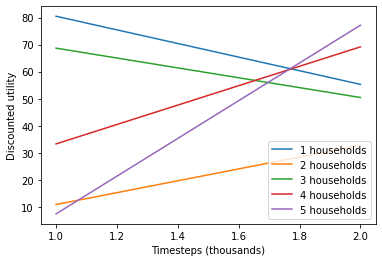

In [6]:
""" STEP 5 (optional): Organize and Plot """

# global experiment name
if len(exp_names) > 1:
    EXP_LABEL = DEVICE + f"_multi_firm_"
    if TEST == True:
        EXP_NAME = EXP_LABEL + ENV_LABEL + "_test_" + DATE + ALGO
    else:
        EXP_NAME = EXP_LABEL + ENV_LABEL + "_run_" + DATE + ALGO


# create CSV with information on each experiment
if SAVE_EXP_INFO:
    progress_csv_dirs = [exp_dirs[i] + "/progress.csv" for i in range(len(exp_dirs))]

    # Create CSV with economy level
    exp_dict = {
        "n_agents": n_firms_LIST,
        "exp_names": exp_names,
        "exp_dirs": exp_dirs,
        "progress_csv_dirs": progress_csv_dirs,
        "best_rewards": best_rewards,
        "checkpoints": checkpoints,
        # "best_config": best_configs,
    }
    # for i in range(len(exp_dict.values())):
    #     print(type(exp_dict.values()[i]))
    print(
        "exp_names =",
        exp_names,
        "\n" "exp_dirs =",
        exp_dirs,
        "\n" "progress_csv_dirs =",
        progress_csv_dirs,
        "\n" "best_rewards =",
        best_rewards,
        "\n" "checkpoints =",
        checkpoints,
        # "\n" "best_config =",
        # best_configs,
    )

    with open(OUTPUT_PATH_EXPERS + "expINFO_" + EXP_NAME + ".json", "w+") as f:
        json.dump(exp_dict, f)

    # exp_df = pd.DataFrame(exp_dict)
    # exp_df.to_csv(OUTPUT_PATH_EXPERS + "exp_info" + EXP_NAME + ".csv")
    print(OUTPUT_PATH_EXPERS + "expINFO_" + EXP_NAME + ".json")

# Plot and save progress
if PLOT_PROGRESS:
    for i in range(len(exp_names)):
        learning_plot = sn.lineplot(
            data=learning_dta[i],
            y=f"{i+1} households",
            x="episodes_total",
        )
    learning_plot = learning_plot.get_figure()
    plt.ylabel("Discounted utility")
    plt.xlabel("Timesteps (thousands)")
    plt.legend(labels=[f"{i+1} households" for i in range(len(learning_dta))])
    learning_plot.savefig(OUTPUT_PATH_FIGURES + "progress_" + EXP_NAME + ".png")

# Save progress as CSV
if SAVE_PROGRESS_CSV:
    # merge data
    learning_dta = [df.set_index("episodes_total") for df in learning_dta]
    learning_dta_merged = pd.concat(learning_dta, axis=1)
    learning_dta_merged.to_csv(OUTPUT_PATH_EXPERS + "progress_" + EXP_NAME + ".csv")

""" Annex_env_hyp: For Environment hyperparameter tuning"""

# # We create a list that contain the main config + altered copies.
env_configs = [env_config]
for i in range(1, 15):
    env_configs.append(env_config.copy())
    env_configs[i]["parameteres"] = (
        {
            "depreciation": np.random.choice([0.02, 0.04, 0.06, 0.08]),
            "alpha": 0.3,
            "phi": 0.3,
            "beta": 0.98,
        },
    )
    env_configs[i]["bgt_penalty"] = np.random.choice([1, 5, 10, 50])